In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("/notebooks/JAXGym")

In [3]:
import jax
import jax.numpy as jnp

import flax
from flax import linen as nn  # Linen API
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses
import optax                           # Common loss functions and optimizers

from flax.training.train_state import TrainState

import gymnax

import matplotlib.pyplot as plt

In [4]:
from models.base_model import BaseModel, NormalDistPredictor, AffinedTanh
from models.base_q_estimator import BaseQEstimator

from agents.DDPG import DDPG

from samplers.sampler import Sampler

from off_policy_trainer import build_trainer

from structs import Buffer

from utils.callback import tqdm_callback

Tips for tuning DDPG:

1. polyak_coef should be tuned along with the learning rates
2. if using constant action noise and if the action noise set to too big, actions at test time will be quite random (especially at test time);
   on the contrary, if the noise is too small, the learning will be slow and would converge to sub-optimal policies

TODO:

1. Noise scale decreasing over steps

In [17]:
action_limits = (-2, 2)

actor_lr = 1e-2
critic_lr = 1e-2

discount = 0.99

num_envs = 8

batch_size = 128
polyak_coef = 0.95
noise_scale = 0.1

iters = 1000

max_episode_steps = 400

steps_per_update = 8

buffer_size_before_training = 2000

buffer_size = int(1e4)

env_name = "Pendulum-v1"

In [13]:
env, env_params = gymnax.make(env_name)

obs_size = env.observation_space(env_params).shape[0]
action_size = env.action_space(env_params).shape[0]

In [19]:
cpu_device = jax.devices('cpu')[0]
gpu_device = jax.devices('gpu')[0]

with jax.default_device(gpu_device):
    key = jax.random.PRNGKey(64)
    
    dummy = jnp.ones([1, obs_size])
    action_dummy = jnp.ones([1, action_size])
    actor_init_key, critic_init_key, key = jax.random.split(key, 3)
    
    actor_model = nn.Sequential([BaseModel(hidden_size = 128, num_layers = 2), nn.Dense(action_size), AffinedTanh(limits = action_limits)])
    actor_params = actor_model.init(actor_init_key, dummy)['params']
    actor_tx = optax.adam(actor_lr)
    actor = TrainState.create(apply_fn=actor_model.apply,
                              params=actor_params,
                              tx=actor_tx,
                              )
    
    critic_model = nn.Sequential([BaseQEstimator(hidden_size = 128, num_layers = 2), nn.Dense(features = 1)])
    critic_params = critic_model.init(critic_init_key, dummy, action_dummy)['params']
    critic_tx = optax.adam(critic_lr)
    critic = TrainState.create(apply_fn=critic_model.apply,
                              params=critic_params,
                              tx=critic_tx,
                              )
    
    agent = DDPG(discount, polyak_coef, noise_scale, action_limits)
    
    buffer = Buffer(
        jnp.zeros((num_envs, buffer_size, obs_size)),
        jnp.zeros((num_envs, buffer_size, 1)),
        jnp.zeros((num_envs, buffer_size, action_size)),
        jnp.zeros((num_envs, buffer_size, 1)),
        jnp.zeros((buffer_size,)),
        0
    )

    sampler = Sampler(batch_size)
    
    logger = jnp.zeros((iters, 1))

    fori_body = build_trainer(agent, sampler, env, env_params, num_envs, obs_size, action_size, max_episode_steps, buffer_size_before_training, steps_per_update, tqdm_callback(iters))
    
    carry = (actor, critic, actor.params, critic.params, buffer, logger, key)
    carry = jax.lax.fori_loop(0, iters, fori_body, carry)

100%|██████████| 1000/1000 [01:45<00:00, 13.01it/s, Reward=-160.58636]

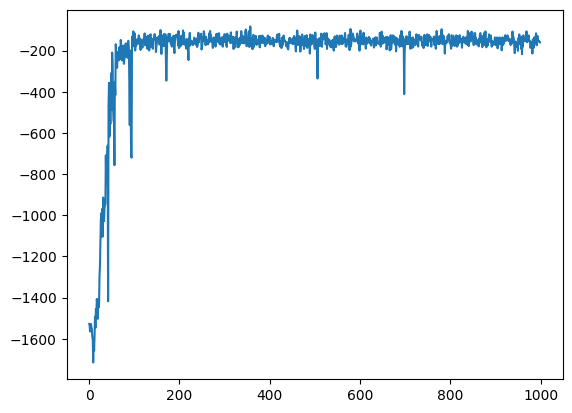

In [20]:
plt.clf()
plt.gca().set_aspect('auto')
plt.plot(carry[-2][:])
plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:252: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'jaxlib.xla_extension.ArrayImpl'>
  logger.warn(
MovieWriter imagemagick unavailable; using Pillow instead.
  0%|          | 0/1000 [07:22<?, ?it/s]


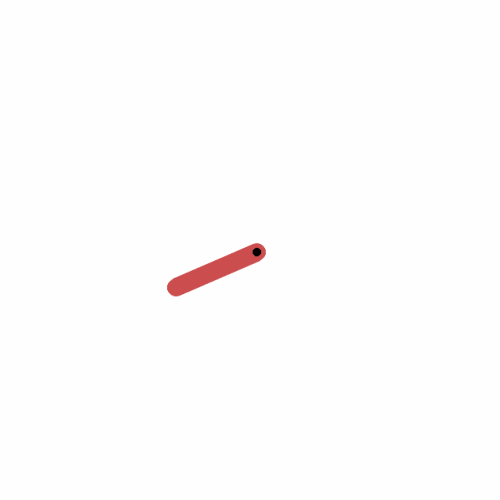

In [11]:
from utils.render import save_frames_as_gif

from IPython.display import Image
from tqdm.notebook import tqdm
import gym

actor = carry[0]

gym_env = gym.make(env_name, render_mode="rgb_array")

obs, _ = gym_env.reset()
frames = []
for t in tqdm(range(500)):
    frames.append(gym_env.render())
    action = agent.suggest_action(jnp.expand_dims(obs, 0), actor)[0]
    obs, _, done, _, _ = gym_env.step(action)
    if done:
        break
        
gym_env.close()

save_frames_as_gif(frames, filename = "tmp.gif")

Image(open('tmp.gif','rb').read())